In [35]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import holidays
from geopy.distance import geodesic
import datetime
from sklearn.model_selection import train_test_split

In [76]:
df = pd.read_csv("TaxiFare.csv")
df.head(3)

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2


# EDA and Feature Engineering

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [78]:
# checking for null
df.isnull().sum()

unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

In [79]:
df.drop(columns="unique_id", inplace=True)

# convert UTC to NYC timezone
df["nyc_time"] = pd.to_datetime(df["date_time_of_pickup"]) - pd.Timedelta(hours=4)
df.drop(columns="date_time_of_pickup", inplace=True)

df.head(2)

,amount,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger,nyc_time
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15 13:26:21+00:00
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05 12:52:16+00:00


In [80]:
# extracting months, years, hours, minutes from timestamp

df["year"] = df["nyc_time"].dt.year
df["month"] = df["nyc_time"].dt.month

df["hours"] = df["nyc_time"].dt.hour
df["minutes"] = df["nyc_time"].dt.minute

In [81]:
# calculating ride start time out of 100 instead of 60 minutes

def minute_convertor(x):
    if x < 15:
        return 0
    if x < 30:
        return 0.25
    if x < 45:
        return 0.5
    return 0.75


df["ride_start_time"] = df["hours"] + df["minutes"].apply(lambda x: minute_convertor(x))

In [82]:
# marking weekends
df["weekend/holiday"] = np.where(df["nyc_time"].dt.day_of_week > 4, 1,0)

# marking holidays
nyc_holidays = holidays.US(years = df["year"].unique(), state="NY")
df["weekend/holiday"] = np.where(df["nyc_time"].dt.date.isin(nyc_holidays),1, df["weekend/holiday"])

In [83]:
# dropping latittudes and longitudes outside of NYC

min_lat, max_lat =  40.3, 45.1
min_long, max_long = -71.5, -79.5

pickup_mask = (df["latitude_of_pickup"] >= min_lat) & (df["latitude_of_pickup"] <= max_lat) \
                & (df["longitude_of_pickup"] <= min_long) & (df["longitude_of_pickup"] >= max_long)
droppoff_mask = (df["latitude_of_dropoff"] >= min_lat) & (df["latitude_of_dropoff"] <= max_lat) \
                & (df["longitude_of_dropoff"] <= min_long) & (df["longitude_of_dropoff"] >= max_long)

nyc_df = df[(pickup_mask) & (droppoff_mask)].copy()

In [84]:
# calculatiing haversine distance
def haversine_distance(row):
    """
    Function that calculates Haversine Distance between pair of cordinates(lat, long)
    """
    pickup = (row.loc["latitude_of_pickup"], row.loc["longitude_of_pickup"])
    drop = (row.loc["latitude_of_dropoff"], row.loc["longitude_of_dropoff"])
    distance = geodesic(pickup, drop).km
    return distance

nyc_df["haversine_distance"] = nyc_df.apply(lambda x: haversine_distance(x), axis=1)    

In [85]:
nyc_df["no_of_passenger"].value_counts()

no_of_passenger
1    34048
2     7252
5     3381
3     2146
4      992
6      976
0      159
Name: count, dtype: int64

In [89]:
nyc_df["amount"].sort_values()[:10]

42337   -5.00
13032   -3.00
2039    -2.90
2486    -2.50
36722   -2.50
47302    0.00
27891    0.00
10002    0.00
2780     0.01
10705    2.50
Name: amount, dtype: float64

In [91]:
# dropping no_of_passenger = 0
nyc_df.drop(nyc_df[nyc_df["no_of_passenger"]==0].index, inplace=True)

# dropping where amount < 2$
nyc_df.drop(nyc_df[nyc_df["amount"] < 2].index, inplace=True)

In [92]:
nyc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48786 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   amount                48786 non-null  float64            
 1   longitude_of_pickup   48786 non-null  float64            
 2   latitude_of_pickup    48786 non-null  float64            
 3   longitude_of_dropoff  48786 non-null  float64            
 4   latitude_of_dropoff   48786 non-null  float64            
 5   no_of_passenger       48786 non-null  int64              
 6   nyc_time              48786 non-null  datetime64[ns, UTC]
 7   year                  48786 non-null  int32              
 8   month                 48786 non-null  int32              
 9   hours                 48786 non-null  int32              
 10  minutes               48786 non-null  int32              
 11  ride_start_time       48786 non-null  float64            
 12  weekend/h

<Axes: xlabel='amount', ylabel='Count'>

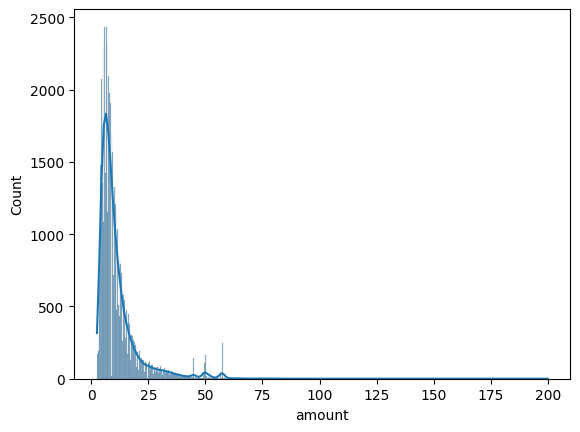

In [101]:
# output column
sns.histplot((nyc_df["amount"]), kde=True)

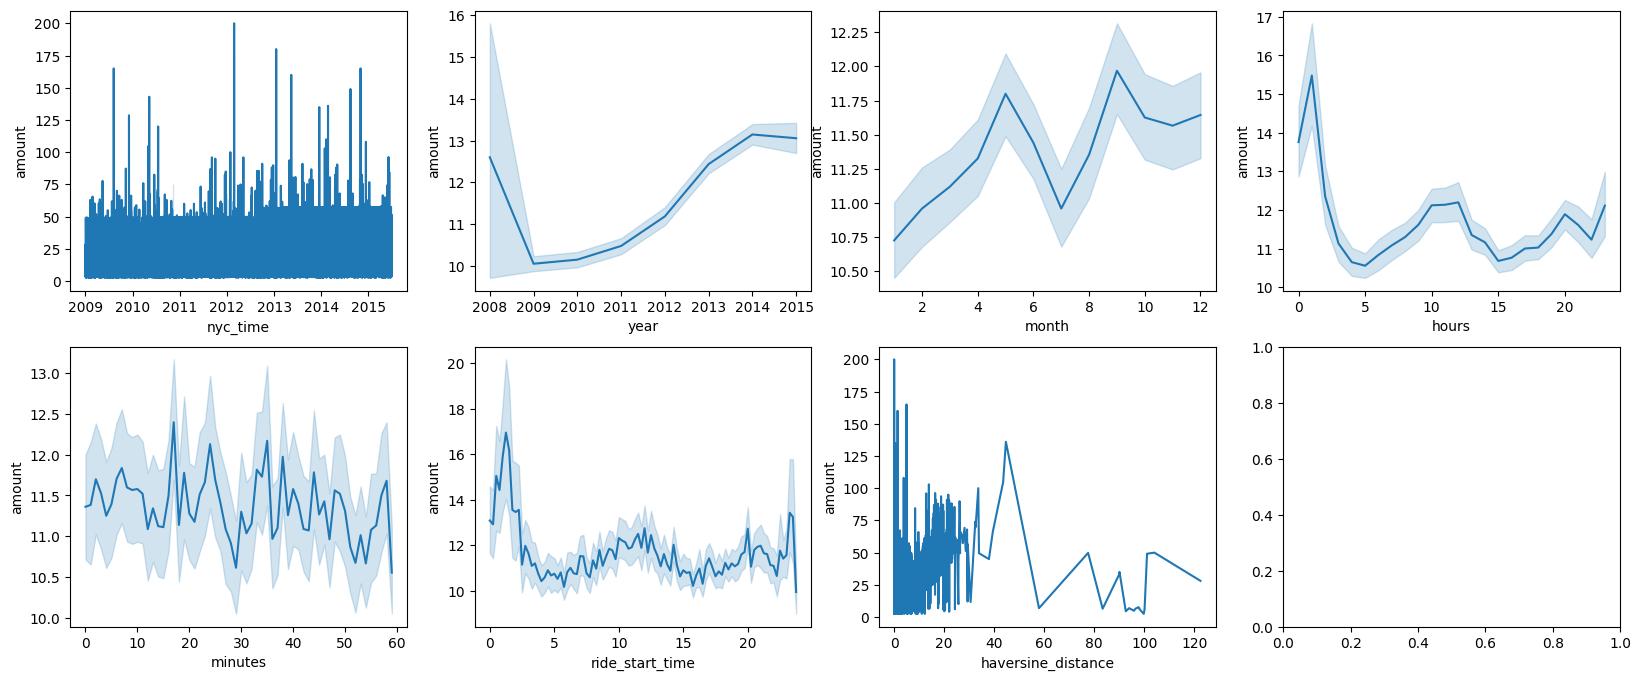

In [105]:
line_plot = ['nyc_time', 'year', 'month', 'hours', 'minutes', 'ride_start_time', 'haversine_distance']
bar_chart = ['no_of_passenger','weekend/holiday']

fig, axs = plt.subplots(2,4, figsize=(20,8))
for ind, col in enumerate(line_plot):
    sns.lineplot(nyc_df, x=col, y="amount", ax=axs[ind//4, ind%4])

In [152]:
x = df.drop(columns="amount")
y = df["amount"]
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=16)